In [1]:
import ipywidgets as widgets

path = widgets.Text(
    value = 'C:\\Users\\inst\\Documents\\GitHub\\image_segmentation\\data\\Fe3S_S08_2um.tiff',
    placeholder='Type something',
    description='File path:',
    disabled=False
)

display(path)


Text(value='C:\\Users\\inst\\Documents\\GitHub\\image_segmentation\\data\\Fe3S_S08_2um.tiff', description='Fil…

In [2]:
%matplotlib inline
import ipyvolume as ipv
import matplotlib.pyplot as plt
from skimage import data, io, filters

from skimage import data, io, filters
## C:\Users\inst\SynologyDrive\Master\Exp\Hi-am\data\2019-04-10 - Issa - Fe3Si -S08 (unlabelled, green)_2um scan_recon.tiff
stack = io.imread(path.value).T[:,:,10]

Text(0.5, 1.0, 'histogram of gray values')

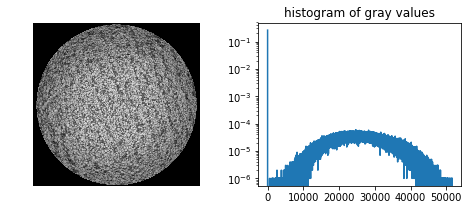

In [10]:
from skimage.exposure import histogram

hist, hist_centers = histogram(stack,nbins=256, source_range='image', normalize=True)

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(stack, cmap=plt.cm.gray, interpolation='nearest')
axes[0].axis('off')
axes[1].plot(hist_centers, hist)
axes[1].set_yscale('log')
axes[1].set_title('histogram of gray values')



(-0.5, 1012.5, 991.5, -0.5)

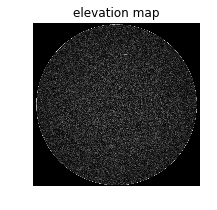

In [11]:
from skimage.filters import sobel

elevation_map = sobel(stack)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(elevation_map, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('elevation map')
ax.axis('off')

(-0.5, 1012.5, 991.5, -0.5)

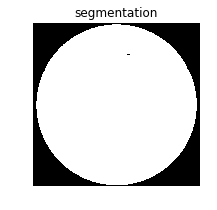

In [23]:
from skimage import morphology
import numpy as np

markers = np.zeros_like(stack)
markers[stack == 0] = 1
markers[stack > 49000] = 2

segmentation = morphology.watershed(elevation_map, markers)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(segmentation, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('segmentation')
ax.axis('off')


Text(0.5, 1.0, 'histogram of gray values')

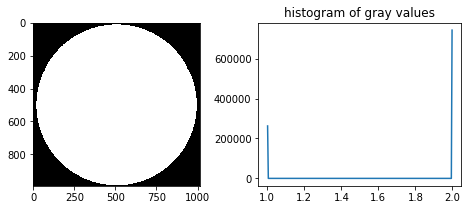

In [42]:
from skimage.morphology import reconstruction

seed = np.copy(segmentation)
seed[1:-1, 1:-1] = segmentation.max()
mask = segmentation

filled = reconstruction(seed, mask, method='erosion')


hist, hist_centers = histogram(filled)

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(filled, cmap=plt.cm.gray)
axes[1].plot(hist_centers, hist)
axes[1].set_title('histogram of gray values')

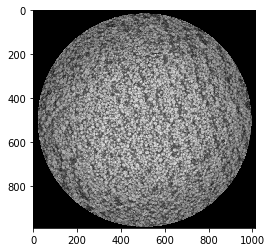

In [43]:
from skimage.restoration import denoise_nl_means
import ipyvolume as ipv
import numpy.ma as ma


ma_stack = ma.masked_where(filled == 1, stack)
cleaned = denoise_nl_means(ma_stack,patch_size=3,multichannel=False)

fig, ax = plt.subplots(figsize=(5, 4))
ax.imshow(cleaned, cmap='gray')

In [44]:
ma_cleaned = ma.masked_where(filled == 1, cleaned)

print(cleaned.shape)

print(ma.count_masked(ma_cleaned))

(992, 1013)
262552


In [45]:
from sklearn.cluster import KMeans
import numpy as np
from skimage.viewer import ImageViewer

kmean_input = []

x,y = ma_cleaned.shape

for i in range(x):
    for j in range(y):
        if(ma_cleaned[i,j] != ma.masked):
            kmean_input.append(np.array([i,j,ma_cleaned[i,j]]))
        
print(kmean_input)

kmeans = KMeans(n_clusters=2,n_jobs=2)
bined = kmeans.fit_predict(kmean_input)

new_img = np.zeros(cleaned.shape)

for j in range(len(kmean_input)):
    index =  kmean_input[j][0:2]
    val = bined[j]
    new_img[int(index[0]),int(index[1])] = val

fig, ax = plt.subplots(figsize=(5, 4))
ax.imshow(new_img, cmap='gray')


[]


ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [33]:
ma_den = ma.masked_where(filled == 0, new_img)

porosity = np.mean(ma_den)
print(porosity)

0.39124148170556955
